In [ ]:
# ..... run MN cross-species ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)
library(dplyr)

In [3]:
# get orthologs
# om = read.delim('turtle/turtle_chicken_orthologs_biomart.txt', sep = '\t')
# om <- om[which(om[,1]!='' & om[,2]!='' & !is.na(om[,5]) & om[,5]==1 & om[,4]=='ortholog_one2one'),]

om = read.delim('lizard/lizard_turtle_orthologs_eggNOG.txt', sep = '\t')
om <- om[which(!is.na(om$lizard_gene) & !is.na(om$ortholog_name)),]
om <- om[,c('lizard_gene', 'ortholog_name')]
dim(om)
om[1,]

[1] 27963     2

lizard_gene ortholog_name
1 ARHGEF10    ARHGEF10

In [9]:
# load data
get_seurat_obj <- function(currstage1, path0){
    
    sc1 = readRDS(paste0(path0, '/', currstage1, '_integrated_cca.rds'))

    df1 = read.delim(paste0(path0, '/', currstage1, '_Knight-Schrijver_celltypes.csv'), sep = ',')
    ids = match(rownames(sc1@meta.data), df1$barcode)
    sc1$class = df1$class[ids]
    sc1$celltype = df1$final_celltype[ids]
    
    # convert only immature_other into subclass labels
    sc1$celltype2 = sc1$class
    sc1$celltype2[sc1$class=='Immature_other'] <- sc1$celltype[sc1$class=='Immature_other']
#     sc1$cluster = df1$cluster[ids]

    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    
    # remove cell types with <50 cells across all samples combined
    sc1 <- sc1[,!(sc1$celltype2 %in% names(which(table(sc1$celltype2)<50)))]
    sc1$species = path0
    sc1$stage = currstage1
    return(sc1)
}

# load data
get_seurat_obj2 <- function(species, currstage1){
    
    sc1 = readRDS(paste0(species, '/', currstage1, '_integrated_cca.rds'))

#     df1 = read.delim(paste0(currstage1, '_Knight-Schrijver_celltypes.csv'), sep = ',')
    df1 = read.delim(paste0(species, '/', currstage1, '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    
    ids = match(rownames(sc1@meta.data), df1$barcode)
    
#     sc1$class = df1$class[ids]
#     sc1$celltype = df1$final_celltype[ids]
#     sc1$cluster = df1$cluster[ids]
    
    sc1$stage = currstage1
    sc1$celltype2 = df1$class[ids]
    sc1$celltype = df1$monocle_label[ids]
    sc1$species = species

    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    return(sc1)
}

In [58]:
# load individual sample files
sce1 = get_seurat_obj('stage9', 'lizard')
sce2 = get_seurat_obj('stage13', 'lizard')
sce3 = get_seurat_obj('stage16', 'lizard')

In [59]:
# load individual sample files
sce4 = get_seurat_obj('stage14', 'turtle')
sce5 = get_seurat_obj('stage17', 'turtle')
sce6 = get_seurat_obj('stage21', 'turtle')

# load individual sample files
# sce4 = get_seurat_obj('stage23', 'chicken')
# sce5 = get_seurat_obj('stage28', 'chicken')
# sce6 = get_seurat_obj('stage32', 'chicken')

In [61]:
# get metadata
cols = c('species', 'stage', 'sample', 'celltype', 'celltype2')
mtd1 = rbind(sce1@meta.data[,cols], sce2@meta.data[,cols], sce3@meta.data[,cols])
mtd2 = rbind(sce4@meta.data[,cols], sce5@meta.data[,cols], sce6@meta.data[,cols])

# cols = c('species', 'stage', 'celltype', 'celltype2')
# mtd1 = sce1@meta.data[,cols]
# mtd2 = sce2@meta.data[,cols]

In [62]:
# get counts matrices for each species
tmat = cbind(sce1@assays$RNA@counts, sce2@assays$RNA@counts, sce3@assays$RNA@counts)
cmat = cbind(sce4@assays$RNA@counts, sce5@assays$RNA@counts, sce6@assays$RNA@counts)

# tmat = sce1@assays$RNA@counts
# cmat = sce2@assays$RNA@counts

In [63]:
# rename chicken data gene names
rownames(cmat) <- om[match(rownames(cmat), om[,2]),1]
cmat <- cmat[!is.na(rownames(cmat)),]

In [64]:
# subset to common orthologs
common_genes = intersect(rownames(tmat), rownames(cmat))
tmat <- tmat[common_genes,]
cmat <- cmat[common_genes,]

In [65]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(tmat, cmat)),
                           colData = DataFrame(rbind(mtd1, mtd2)))
sce$species_stage = paste0(sce$species, '-', sce$stage)
sce

class: SingleCellExperiment 
dim: 10414 156953 
metadata(0):
assays(1): counts
rownames(10414): LOC132761875 LRFN5 ... ZNF507 TSHZ3
rowData names(0):
colnames(156953): stage9_sample1_9_sample1_AAACCCAAGACCATGG-1
  stage9_sample1_9_sample1_AAACCCAAGTAACGAT-1 ...
  stage21_sample2_TTTGTTGTCATTGTGG-1 stage21_sample2_TTTGTTGTCTATGTGG-1
colData names(6): species stage ... celltype2 species_stage
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [66]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$species_stage)
length(hvg)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

[1] 1276

Time difference of 14.0477 secs

In [67]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species_stage, 
    cell_type = sce$celltype2, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species_stage, 
    cell_type = sce$celltype2, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

In [68]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('.*\\|', '', rownames(aurocsall))

subs2 = c('Endocardial', 'Immature_Cardiomyocytes', 'Cardiomyocytes', 'Smooth_Muscle_Cells',  
          'Myeloid_Immune_Cells', 'Lymphoid_Immune_Cells', 'Pericytes_Stromal', 'Pericytes', 'Fibroblasts',
          'Endothelial_Arterial', 'Endothelial_Venous', 'Endothelial_Capillaries', 'Neuronal_Cells',
          'Immature_Endothelium', 'Immature_FB-like', 'Immature_Neuralcrest',
          'Epicardium_FB-like', 'Epicardium_Meso', 'Epicardium_Proliferating')

subcol2 = c('#29c5f6', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#ff9aba', '#651f7e', '#643b9f', '#358957',
            '#dce775', '#574e3c', '#84b023', '#4900e6',
           '#fc6c85', '#a94064', '#c154c1',
           '#3a9bdc', '#5579c6', '#1260cc')
r1 = c('chicken-stage23', 'chicken-stage28', 'chicken-stage32')
r2 = c('turtle-stage14', 'turtle-stage17', 'turtle-stage21')
r3 = c('lizard-stage9', 'lizard-stage13', 'lizard-stage16')
reg2 = c(r3, r2)

regcols2 = rep(c('#fda638', '#eb7c69', '#459395'), 2)
regcols3 = rep(c('#8dd7bf', '#e77577'), each = 3)

cols1 = subcol2[match(ctypes, subs2)]
cols2 = regcols2[match(exps, reg2)]
cols3 = regcols3[match(exps, reg2)]

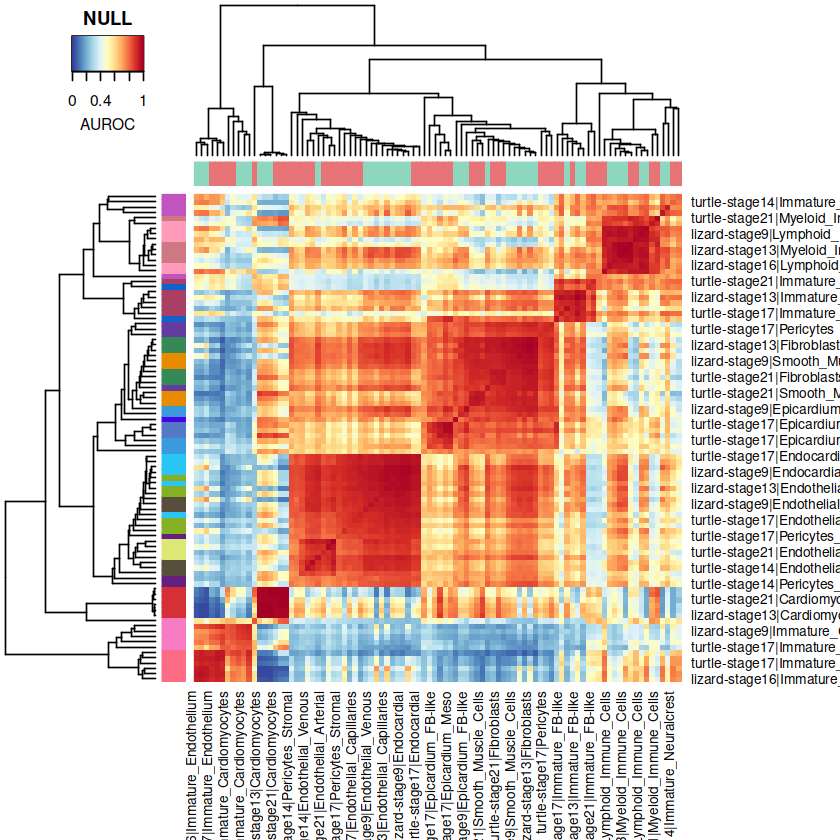

In [69]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-chicken-turtle-mn-all-spe.pdf', width = 10, height = 10)
plotHeatmap(aurocsall, ColSideColors = cols3, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [70]:
# save
save(aurocs1v1, aurocsall, file = 'lizard_turtle_MN_scores.Rdata')

In [38]:
# get top hits
tops = topHits(aurocsall, dat = sce, study_id = sce$species_stage, cell_type = sce$celltype2, threshold = 0.9)
tops$species1 = sub('\\-.*', '', tops[,1])
tops$species2 = sub('\\-.*', '', tops[,2])
tops[tops$species1!=tops$species2,]

Study_ID|Celltype_1                   Study_ID|Celltype_2                 
3  lizard-stage16|Cardiomyocytes         chicken-stage32|Cardiomyocytes      
4  lizard-stage16|Cardiomyocytes         chicken-stage23|Cardiomyocytes      
12 lizard-stage16|Neuronal_Cells         chicken-stage32|Neuronal_Cells      
17 lizard-stage9|Endocardial             chicken-stage23|Endocardial         
18 lizard-stage9|Endocardial             chicken-stage28|Endocardial         
25 lizard-stage9|Fibroblasts             chicken-stage23|Fibroblasts         
26 lizard-stage9|Endocardial             chicken-stage28|Endothelial_Venous  
32 lizard-stage13|Immature_FB-like       chicken-stage32|Immature_FB-like    
34 lizard-stage9|Fibroblasts             chicken-stage23|Smooth_Muscle_Cells 
36 lizard-stage9|Endocardial             chicken-stage28|Pericytes_Stromal   
37 lizard-stage13|Fibroblasts            chicken-stage28|Smooth_Muscle_Cells 
39 chicken-stage28|Endothelial_Venous    lizard-stage16|Endothelial_Venous   
40 lizard-stage9|Endocardial             chicken-stage23|Endothelial_Venous  
42 lizard-stage9|Endocardial             chicken-stage23|Pericytes_Stromal   
44 lizard-stage9|Endothelial_Capillaries chicken-stage28|Endothelial_Arterial
45 lizard-stage16|Immature_FB-like       chicken-stage28|Immature_FB-like    
54 lizard-stage9|Immature_Endothelium    chicken-stage32|Immature_Endothelium
   Mean_AUROC Match_type         species1 species2
3  0.99       Above_0.9          lizard   chicken 
4  0.99       Above_0.9          lizard   chicken 
12 0.98       Reciprocal_top_hit lizard   chicken 
17 0.97       Above_0.9          lizard   chicken 
18 0.97       Above_0.9          lizard   chicken 
25 0.96       Above_0.9          lizard   chicken 
26 0.96       Above_0.9          lizard   chicken 
32 0.95       Above_0.9          lizard   chicken 
34 0.95       Above_0.9          lizard   chicken 
36 0.95       Above_0.9          lizard   chicken 
37 0.95       Above_0.9          lizard   chicken 
39 0.94       Above_0.9          chicken  lizard  
40 0.94       Above_0.9          lizard   chicken 
42 0.94       Above_0.9          lizard   chicken 
44 0.94       Above_0.9          lizard   chicken 
45 0.94       Above_0.9          lizard   chicken 
54 0.90       Above_0.9          lizard   chicken

In [39]:
# only keep common cells
mtd0 = data.frame(colData(sce))
temp = data.frame(mtd0 %>% group_by(celltype) %>% summarise(count = length(unique(species))))
common_celltypes = temp$celltype[temp$count==2]

In [40]:
# plot heatmaps #
ctypes_all = sub('.*\\|', '', rownames(aurocsall))
keep_ids = which(ctypes_all %in% common_celltypes)
aurocsmat = aurocs1v1[keep_ids,keep_ids]

exps = sub('\\|.*', '', rownames(aurocsmat))
exps <- sub('\\-.*', '', exps)
ctypes = sub('.*\\|', '', rownames(aurocsmat))

subs2 = c('Intermediate_neuronal_progenitors', 'Hepatocytes', 'Cardiomyocytes', 'Muscle_cells',  
          'Intestine', 'Lung_and_airway', 'Olfactory_sensory_neurons', 'CNS_neurons', 'Mesoderm',
          'Primitive_erythroid', 'White_blood_cells', 'Definitive_erythroid', 
          'Mast_cells', 'Megakaryocytes', 'B_cells',
          'Neuronal_Cells', 'Endothelium', 'Epithelial_cells', 'Eye_and_other',
          'Neural_crest_PNS_glia', 'Neural_crest_PNS_neurons', 'Neuroectoderm_and_glia')

subcol2 = c('#29c5f6', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#ff9aba', '#651f7e', '#643b9f', '#088f8f',
            '#dce775', '#574e3c', '#84b023', 
            '#708238', '#358957', '#90ee90',
            '#4900e6', '#fc6c85', '#a94064', '#c154c1',
           '#3a9bdc', '#5579c6', '#1260cc')

reg2 = c('chicken', 'turtle')
regcols2 = c('#8dd7bf', '#e77577')

cols1 = subcol2[match(ctypes, subs2)]
cols2 = regcols2[match(exps, reg2)]

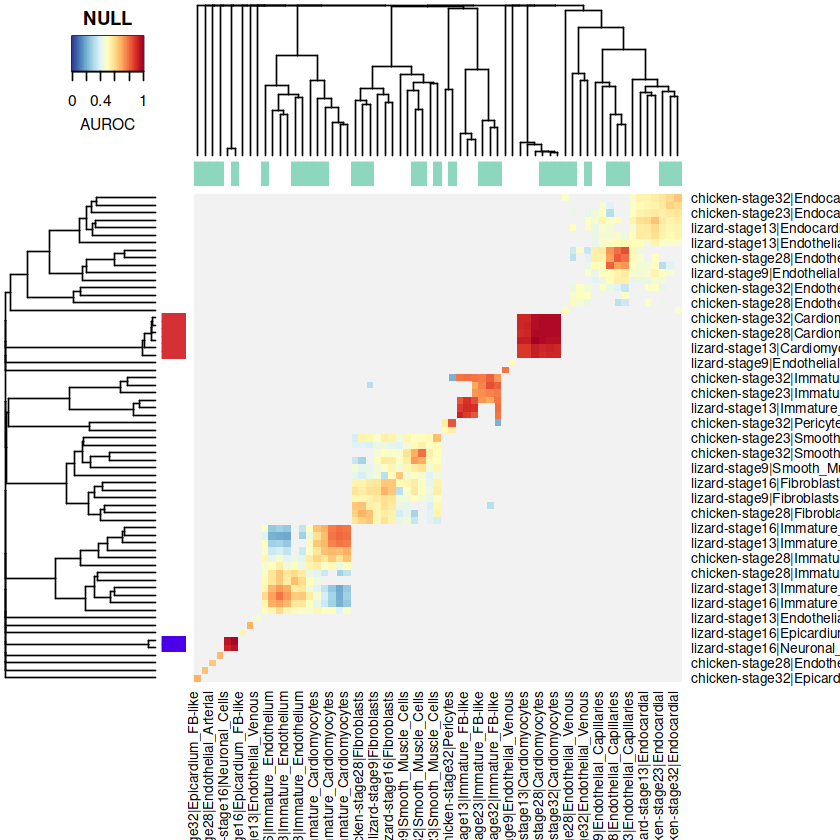

In [41]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-chicken-turtle-mn-all-spe.pdf', width = 10, height = 10)
plotHeatmap(aurocsmat, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [31]:
# make shorter matrices for broad cell types
mn_all = aurocsall[keep_ids,keep_ids]
mn_1v1 = aurocs1v1[keep_ids,keep_ids]
rnames = paste0(exps, '|', ctypes)
rownames(mn_all) = rnames
colnames(mn_all) = rnames
rownames(mn_1v1) = rnames
colnames(mn_1v1) = rnames

In [32]:
# save
save(mn_all, mn_1v1, file = 'lizard_chicken_MN_scores.Rdata')

In [ ]:
# .... plot across all 3 species ..... #

In [94]:
# function to get aurocs from each species-pair MN matrix
get_aurocs <- function(score_mat, celltypes, mn_mat){
    ctypes = rownames(mn_mat)
    ids = match(ctypes, celltypes)
    score_mat[ids,ids] = mn_mat
    return(score_mat)
}

In [74]:
load('turtle_chicken_MN_scores.Rdata')
mat1 = aurocs1v1
load('lizard_chicken_MN_scores.Rdata')
mat2 = aurocs1v1
load('lizard_turtle_MN_scores.Rdata')
mat3 = aurocs1v1

In [95]:
ctypes = c('Endocardial', 'Immature_Cardiomyocytes', 'Cardiomyocytes', 'Smooth_Muscle_Cells',  
          'Myeloid_Immune_Cells', 'Lymphoid_Immune_Cells', 'Pericytes_Stromal', 'Pericytes', 'Fibroblasts',
          'Endothelial_Arterial', 'Endothelial_Venous', 'Endothelial_Capillaries', 'Neuronal_Cells',
          'Immature_Endothelium', 'Immature_FB-like', 'Immature_Neuralcrest',
          'Epicardium_FB-like', 'Epicardium_Meso', 'Epicardium_Proliferating')

spe_stages = c('chicken-stage23', 'chicken-stage28', 'chicken-stage32',
               'turtle-stage14', 'turtle-stage17', 'turtle-stage21',
               'lizard-stage9', 'lizard-stage13', 'lizard-stage16')

rows1 = paste0(rep(spe_stages, each = length(ctypes)), '|', rep(ctypes, length(spe_stages)))
fullmat = matrix(NA, nrow = length(rows1), ncol = length(rows1))

# get all scores
fullmat = get_aurocs(fullmat, rows1, mat1)
fullmat = get_aurocs(fullmat, rows1, mat2)
fullmat = get_aurocs(fullmat, rows1, mat3)

# remove empty rows
rm_id = which(rowSums(is.na(fullmat))==length(rows1))
fullmat <- fullmat[-rm_id, -rm_id]

# assign cell labels
rownames(fullmat) = rows1[-rm_id]
colnames(fullmat) = rows1[-rm_id]
fullmat[1:3,1:3]

chicken-stage23|Endocardial
chicken-stage23|Endocardial             0.5473213                  
chicken-stage23|Immature_Cardiomyocytes        NA                  
chicken-stage23|Cardiomyocytes                 NA                  
                                        chicken-stage23|Immature_Cardiomyocytes
chicken-stage23|Endocardial                    NA                              
chicken-stage23|Immature_Cardiomyocytes 0.6540285                              
chicken-stage23|Cardiomyocytes                 NA                              
                                        chicken-stage23|Cardiomyocytes
chicken-stage23|Endocardial                    NA                     
chicken-stage23|Immature_Cardiomyocytes        NA                     
chicken-stage23|Cardiomyocytes          0.9789911

In [96]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(fullmat))
cells = sub('.*\\|', '', rownames(fullmat))

subcol2 = c('#29c5f6', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#ff9aba', '#651f7e', '#643b9f', '#358957',
            '#dce775', '#574e3c', '#84b023', '#4900e6',
           '#fc6c85', '#a94064', '#c154c1',
           '#3a9bdc', '#5579c6', '#1260cc')
regcols2 = rep(c('#fda638', '#eb7c69', '#459395'), each = 3)

cols1 = subcol2[match(cells, ctypes)]
cols2 = regcols2[match(exps, spe_stages)]

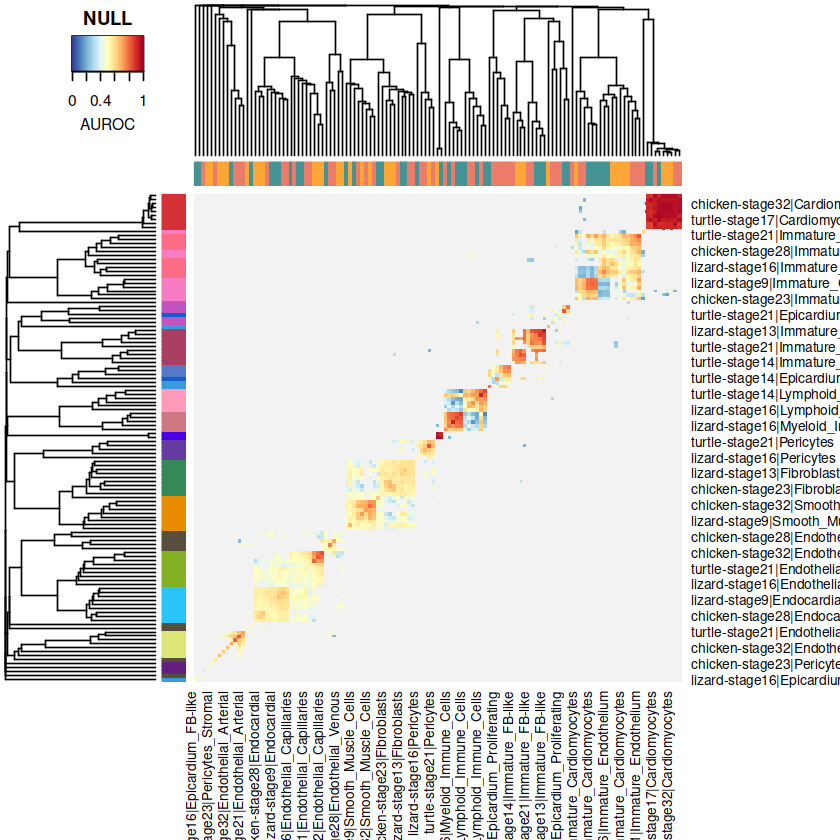

In [98]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-chicken-turtle-mn-1v1-spe.pdf', width = 10, height = 10)
plotHeatmap(fullmat, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()